<a href="https://colab.research.google.com/github/davidzillion/Text_Summarizer_firstatt/blob/main/TextSummarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text Summarizer** 

**Text summarization is the process of creating a short, coherent, and fluent summary of a longer text document and involves the outlining of the text's major points. ... Two different approaches that are used for text summarization are:**
+ Extractive Summarization
    + Extractive summarization aims at identifying the salient information that is then extracted and grouped together to form a concise summary.
+ Abstractive Summarization
    + Abstractive summary generation rewrites the entire document by building internal semantic representation, and then a summary is created using natural language processing.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports 

In [ ]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 300)
warnings.filterwarnings("ignore")

# Read data

In [ ]:
df = pd.read_csv('/content/drive/My Drive/TextSummarizer/Reviews.csv', sep=',') # ,nrows=100000
reviews = df.copy()
reviews
 
# in cleaned_summary[] to avoid error = datatype 'float' has no attribute 'lower' ->
reviews = reviews.astype(str)

# Exploration

### Datatypes and shape 

In [ ]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  object
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568454 non-null  object
 4   HelpfulnessNumerator    568454 non-null  object
 5   HelpfulnessDenominator  568454 non-null  object
 6   Score                   568454 non-null  object
 7   Time                    568454 non-null  object
 8   Summary                 568454 non-null  object
 9   Text                    568454 non-null  object
dtypes: object(10)
memory usage: 43.4+ MB


In [ ]:
reviews.nunique()

Id                        568454
ProductId                  74258
UserId                    256059
ProfileName               218417
HelpfulnessNumerator         231
HelpfulnessDenominator       234
Score                          5
Time                        3168
Summary                   295743
Text                      393579
dtype: int64

In [ ]:
reviews.describe()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
count,568454,568454,568454,568454,568454,568454,568454,568454,568454,568454
unique,568454,74258,256059,218417,231,234,5,3168,295743,393579
top,549821,B007JFMH8M,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",0,0,5,1350345600,Delicious!,"This review will make me sound really stupid, but whatever. I don't really care as long as people find out what's real and can avoid my mistakes.<br /><br />I got my wonderful little sweet Bella Bean when she was a few days shy of three years old. She had been bounced around from house to house ..."
freq,1,913,448,451,303826,270052,363122,1143,2462,199


In [ ]:
reviews.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

### Drop duplicates and Nan values


In [ ]:
#dropping duplicates
reviews.drop_duplicates(subset=['Text'],inplace=True)
#dropping na
reviews.dropna(axis=0,inplace=True)

# Preprocessing

In [ ]:
# dictionary for expanding the contractions
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

# Text cleaning

* Convert everything to lowercase

* Remove HTML tags

* Contraction mapping

* Remove (‘s)

* Remove any text inside the parenthesis ( )

* Eliminate punctuations and special characters

* Remove stopwords

* Remove short words

In [ ]:
reviews['Text'][:2]


0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
1                                                                             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
Name: Text, dtype: object

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words('english'))

def text_cleaner(text, num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:    #removing short word                                             
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [ ]:
cleaned_text = []
for t in reviews['Text']:
  cleaned_text.append(text_cleaner(t,0))

In [ ]:
# the first 2 preprocessed reviews from 'Text' column
cleaned_text[:2]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo']

In [ ]:
cleaned_summary = []
for t in reviews['Summary']:
  cleaned_summary.append(text_cleaner(t,1))

In [ ]:
cleaned_summary[:2]

['good quality dog food', 'not as advertised']

In [ ]:
reviews['cleaned_text'] = cleaned_text
# cleaned_text

In [ ]:
reviews['cleaned_summary'] = cleaned_summary
# cleaned_summary

# Drop empty rows

In [ ]:
reviews.replace('', np.nan, inplace=True)
reviews.dropna(axis=0, inplace=True)

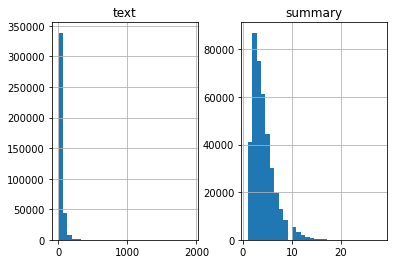

In [ ]:
# fix the max length of the sequence
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# fill the lists with sentences
for i in reviews['cleaned_text']:
  text_word_count.append(len(i.split()))

for i in reviews['cleaned_summary']:
  summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text' : text_word_count, 'summary' : summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
# max majority summary length is 8
counter= 0
for i in reviews['cleaned_summary']:
  if(len(i.split())<=8):
    counter=counter+1
print(counter/len(reviews['cleaned_summary']) * 100,'% of the summaries have length <= 8.')

94.58073835214775 % of the summaries have length <= 8.


In [ ]:
# put max length of reviews to 30
max_text_len = 30
max_summary_len = 8

In [ ]:
# select all summaries and reviews with legth <= max_summary_len and max_text_len
cleaned_text = np.array(reviews['cleaned_text'])
cleaned_summary = np.array(reviews['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
  if(len(cleaned_summary[i].split())<= max_summary_len and len(cleaned_text[i].split())<= max_text_len):
    short_text.append(cleaned_text[i])
    short_summary.append(cleaned_summary[i])

df = pd.DataFrame({'text' : short_text, 'summary' : short_summary})

### Tokenize start and end of summary, tokens should not appear in data

In [ ]:
# tokenize start and end of summary, tokens should not appear in data
df['summary'] = df['summary'].apply(lambda x : 'strtsum' + x + 'finishim') # strtsum / startsummarization , finshhim 

In [ ]:
# preparing (20%)test and (80%)train set 
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(np.array(df['text']), np.array(df['summary']), test_size = 0.2, random_state = 42, shuffle=True)

# Define Text Tokenizer

In [ ]:
# convert word sequences to integer sequences and build vocabulary with tokenizer for text and summary
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# tokenize reviews on train data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

### Rare words as threshold

In [ ]:
# define threshold 
# word counts < 4 = rare word
thresh = 4

counter = 0 # gives number of rare words 
total_count = 0 # size of vocabulary
freq = 0
total_freq = 0

for key, value in x_tokenizer.word_counts.items():
  total_count = total_count + 1
  total_freq = total_freq + value
  if (value < thresh):
    counter = counter + 1
    freq = freq + value

print((counter/total_count)*100, '% of rare words in vocabulary')
print('Total Coverage of rare words: ', (freq/total_freq)*100)

67.79578951445781 % of rare words in vocabulary
Total Coverage of rare words:  1.5252281948080555


In [ ]:
# (total_count - counter) = top most common words in reviews
# tokenizer for reviews on train data

x_tokenizer = Tokenizer(num_words = total_count - counter)
x_tokenizer.fit_on_texts(list(x_train))

# convert text sequences into integer sequences
x_train_seq = x_tokenizer.texts_to_sequences(x_train)
x_test_seq = x_tokenizer.texts_to_sequences(x_test)

# padding zero upto max length
x_train = pad_sequences(x_train_seq, maxlen = max_text_len, padding='post')
x_test = pad_sequences(x_test_seq, maxlen = max_text_len, padding='post')

# size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

In [ ]:
x_voc

16629

# Define Summary Tokenizer

In [ ]:
# tokenizer for reviews on train data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

### Rare words as thresholds

In [ ]:
# rare word = count < 6

thresh = 6

counter = 0
total_count = 0
freq = 0 
total_freq = 0

for key, value in y_tokenizer.word_counts.items():
  total_count = total_count + 1
  total_freq = total_freq + value
  if(value < thresh):
    counter = counter + 1
    freq = freq + value

print((counter / total_count) * 100, '% of rare words in vocabulary')
print('Total Coverage of rare words:', (freq / total_freq) * 100)

79.2825001541022 % of rare words in vocabulary
Total Coverage of rare words: 7.745322673400783


In [ ]:
# define tokenizer with top most common words for summary
# tokenizer for reviews on train data

y_tokenizer = Tokenizer(num_words = total_count - counter)
y_tokenizer.fit_on_texts(list(y_train))

# convert text seq into integer seq
y_train_seq = y_tokenizer.texts_to_sequences(y_train)
y_test_seq = y_tokenizer.texts_to_sequences(y_test)

# padding zero upto max length
y_train = pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_test = pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')

# vocabulary size
y_voc = y_tokenizer.num_words + 1

In [ ]:
# word count of start token = length of train data
# y_tokenizer.word_counts['happy']

#y_tokenizer.word_counts['strtsum'], len(y_train)

In [ ]:
# drop rows that contains 'strtsum'(start) and 'finishim'(end) tokens

ind = []
for i in range(len(y_train)):
  counter=0
  for j in y_train[i]:
    if j != 0:
      counter = counter + 1
      if(counter==2):
        ind.append(i)

y_train = np.delete(y_train, ind, axis=0)
x_train = np.delete(x_train, ind, axis=0)

In [ ]:
ind = []
for i in range(len(y_test)):
  counter=0
  for j in y_test[i]:
    if j != 0:
      counter = counter + 1
      if(counter==2):
        ind.append(i)

y_test = np.delete(y_test, ind, axis=0)
x_test = np.delete(x_test, ind, axis=0)

# Model

### The code below shows the creation of customer attention layer using tensorflow keras 


In [ ]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K
from typing import Optional


class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, inputs_shape):
        inputs_shape = inputs_shape if isinstance(inputs_shape, list) else [inputs_shape]

        if len(inputs_shape) < 1 or len(inputs_shape) > 2:
            raise ValueError("AttentionLayer expect one or two inputs.")

        # The first (and required) input is the actual input to the layer
        input_shape = inputs_shape[0]

        # Expected input shape consists of a triplet: (batch, input_length, input_dim)
        if len(input_shape) != 3:
            raise ValueError("Input shape for AttentionLayer should be of 3 dimension.")

        self.input_length = int(input_shape[1])
        self.input_dim = int(input_shape[2])
        attention_param_shape = (self.input_dim, 1)

        self.attention_param = self.add_weight(
            name='attention_param',
            shape=attention_param_shape,
            initializer='uniform',
            trainable=True,
            dtype=tf.float32)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        inputs = inputs if isinstance(inputs, list) else [inputs]

        if len(inputs) < 1 or len(inputs) > 2:
            raise ValueError("AttentionLayer expect one or two inputs.")

        actual_input = inputs[0]
        mask = inputs[1] if len(inputs) > 2 else None
        if mask is not None and not (((len(mask.shape) == 3 and mask.shape[2] == 1) or len(mask.shape) == 2)
                                     and mask.shape[1] == self.input_length):
            raise ValueError("`mask` should be of shape (batch, input_length) or (batch, input_length, 1) "
                             "when calling an AttentionLayer.")

        assert actual_input.shape[-1] == self.attention_param.shape[0]

        # (batch, input_length, input_dim) * (input_dim, 1) ==> (batch, input_length, 1)
        attention_weights = K.dot(actual_input, self.attention_param)

        if mask is not None:
            if len(mask.shape) == 2:
                mask = K.expand_dims(mask, axis=2)  # (batch, input_length, 1)
            mask = K.log(mask)
            attention_weights += mask

        attention_weights = K.softmax(attention_weights, axis=1)  # (batch, input_length, 1)
        result = K.sum(actual_input * attention_weights, axis=1)  # (batch, input_length)  [multiplication uses broadcast]
        return result, attention_weights

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]  # (batch, input_dim)

In [ ]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out]) #decoder_outputs, attn_out

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

In [ ]:
# sparse categorical cross entropy as a loss function, convert the integer seq to one-hot vector (due to memory issues)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

### Here i am monitoring the validation loss (val_loss), the 'early stopping' it is used to stop training the nn at the right time by monitoring a user-specified metric.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
# train the model on batch size of 128 and validate it on (20%) the holdout set 

history = model.fit([x_train,y_train[:,:-1]],
                    y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                    epochs=50,
                    callbacks=[early_stop],
                    batch_size=128,
                    validation_data=([x_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

## Plotting

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### here describe the plot

In [ ]:
# dictionary to convert index to word for target and source vocabulary

reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

## Inference for encoder and decoder

In [ ]:
# Encode the input sequence to get the feature vector

encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# to predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
# implementation of the inference process

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# convert Integer seq to a word seq for summary and reviews

def seq2sum(input_seq):
  newString=''
  for i in input_seq:
    if((i != 0 and i != target_word_index['strtsum']) and
       i != target_word_index['finishim']):
      newString = newString + reverse_target_word_index[i] + ' '
      return newString

def seq2text(input_seq):
  newString=''
  for i in input_seq:
    if(i != 0):
      newString = newString + reverse_source_word_index[i] + ' '
      return newString

In [ ]:
for i in range(0,100):
  print('Review: ', seq2text(x_train[i]))
  print('Original summary: ', seq2sum(y_train[i]))
  print('Preducted summary: ', decode_sequence(x_train[i].reshape(1, max_text_len)))
  print('\n')


# Output ...
# Review: gave caffeine shakes heart anxiety attack plus tastes unbelievably bad stick coffee tea soda thanks 
# Original summary: hour 
# Predicted summary:  not worth the money

# Shorter Summarizer


In [ ]:
# Imports
import numpy as np
import networkx as nx
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance


In [ ]:
# Generate clean sentences
def read_article(file_name) :
    file = open(file_name, "r")
    filedata = file.readlines()
    article = filedata[0].split(". ")
    sentences = []
    
    for sentence in article :
        print(sentence)
        sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
        sentences.pop()
        
        return sentences

In [ ]:
def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)

In [ ]:
# similarity matrix
def build_similarity_matrix(sentences, stop_words) :
    # create empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
    
    for idx1 in range(len(sentences)) :
        for idx2 in range(len(sentences)) :
            if idx1 == idx2 : # ignore if bothare same sentences
                continue
                similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)
                
                return similarity_amtrix

In [ ]:
# Generate Summary Method
def generate_summary(file_name, top_n=5) :
    stop_words = stopwords.words('english')
    summarize_text = []
# read and tokenize text
    sentences = read_article(file_name) 
# similarity matrix across sentences
    sentence_similarity_matrix = build_similarity_matrix(sentences, stop_words)
# rank sentences in matirx
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_matrix)
    scores = nx.pagerank(sentence_similarity_graph)
# sort rank and pick top sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
    print("Indexes of top ranked sentence order are", 
         ranked_sentence)
    
    for i in range(top_n) :
        summarize_test.append(" ".join(ranked_sentence[i][1]))
        
# summarize text
    print("Summarize Text: \n", ". ".join(summmarize_text))

In [ ]:
# read text file and use summarizer
example_text = open('/content/drive/My Drive/finished/TextShort.txt', 'r').read().replace('\n', '')

generate_summary(example_text, 4)